# Introduction
This notebook gives an example of how to work with the provided training data and utils.

## To get a better feeling for our problem, let's plot some data
The reward or penalty we get in a substation for following the target voltage is dependent on the deviation of the currently measured voltage $V_m$ from the target voltage $V_t$ and the reactive power $W_Q$.

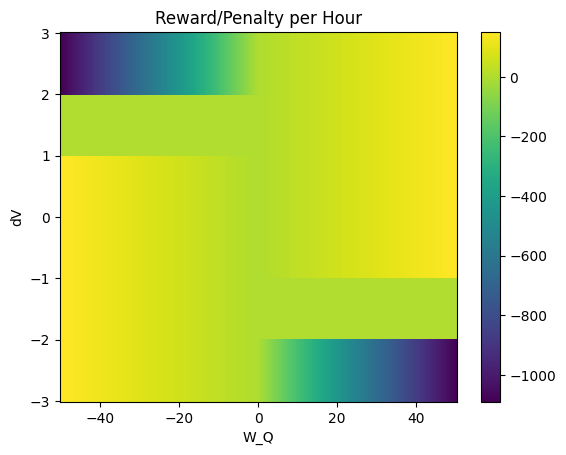

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

from utils.eval import reward_function

# make a 2D sampling grid with edges [-4, 4] and [-50, 50]
dV = np.linspace(-3, 3, 200)
W_Q = np.linspace(-50, 50, 200)
dV_grid, W_Q_grid = np.meshgrid(dV, W_Q)
reward = reward_function(dV_grid, W_Q_grid)

# plot the reward function using pcolormesh
fig, ax = plt.subplots()
im = ax.pcolormesh(W_Q_grid, dV_grid, reward)
fig.colorbar(im, ax=ax)
ax.set_xlabel('W_Q')
ax.set_ylabel('dV')
ax.set_title('Reward/Penalty per Hour')
plt.show()

# Historical Target vs. Real Voltage
Let's plot the target and real voltage for one of the substations in the year 2022.

In [76]:
%autoreload 2
import datetime

import pandas as pd

from utils.feature_eng import reformat_df

raw_a = pd.read_csv('./data/stationB_train.csv', index_col='Ts', sep=';', 
    dtype={
        'Ts': 'str',
        'SignalName': 'str',
        'SignalId': 'int32',
        'MeasurementValue': 'float32',
        'Ts_day': 'int32',
    },
    decimal=',',
    infer_datetime_format=True,
    )
raw_a.index = pd.to_datetime(raw_a.index)
resampled_a = reformat_df(
    raw_a,
    start_time=datetime.datetime(2022, 1, 1),
    end_time=datetime.datetime(2023, 1, 1),
    )

C:\Users\Nicolas Pelzmann\AppData\Local\Temp\ipykernel_43440\150995383.py:8: FutureWarning:

The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.



In [77]:
# plot VNUUIST and VNUUSOL in the same figure with plotly
import plotly.graph_objs as go
from plotly.subplots import make_subplots

fig = make_subplots(rows=2, cols=1, shared_xaxes=True, vertical_spacing=0.05)

fig.add_trace(go.Scatter(x=resampled_a.index, y=resampled_a["WINWINSPHSDL_VNUUIST"], name="WINWINSPHSDL_VNUUIST"), row=1, col=1)
fig.add_trace(go.Scatter(x=resampled_a.index, y=resampled_a["WINWINSPHSDL_VNUUSOL"], name="WINWINSPHSDL_VNUUSOL"), row=1, col=1)
fig.add_trace(go.Scatter(x=resampled_a.index, y=resampled_a["WINWIN110KOMDROQ"], name="WINWIN110KOMDROQ"), row=2, col=1)

fig.update_yaxes(title_text="Voltage in V", row=1, col=1)
fig.update_yaxes(title_text="Reactive Power in Mvar", row=2, col=1)
fig.update_xaxes(title_text="Time", row=2, col=1)

fig.show()

# Electricity Production
Let's also plot the electricity production in Germany and Switzerland for the same period.

In [129]:
prod_ch = pd.read_csv('data/CH_generation_train.csv', index_col=1, sep=';')
prod_ch.index = pd.to_datetime(prod_ch.index.str[19:35], format="%d.%m.%Y %H:%M")

In [131]:
import plotly.graph_objs as go
import pandas as pd

# Select the relevant columns
prod_ch = prod_ch[['Hydro Pumped Storage  - Actual Aggregated [MW]',
                   'Hydro Run-of-river and poundage  - Actual Aggregated [MW]',
                   'Hydro Water Reservoir  - Actual Aggregated [MW]',
                   'Solar  - Actual Aggregated [MW]', 'Waste  - Actual Aggregated [MW]',
                   'Wind Onshore  - Actual Aggregated [MW]']]

# Create a list of traces for each column
traces = []
for col in prod_ch.columns:
    traces.append(go.Scatter(x=prod_ch.index, y=prod_ch[col], name=col))

# Create the figure
fig = go.Figure(data=traces)

# Update the layout
fig.update_layout(title='Electricity Production in Switzerland', xaxis_title='Date', yaxis_title='Power (MW)')

# Show the figure
fig.show()

In [85]:
prod_ch.columns

Index(['Area', 'Biomass  - Actual Aggregated [MW]',
       'Fossil Brown coal/Lignite  - Actual Aggregated [MW]',
       'Fossil Coal-derived gas  - Actual Aggregated [MW]',
       'Fossil Gas  - Actual Aggregated [MW]',
       'Fossil Hard coal  - Actual Aggregated [MW]',
       'Fossil Oil  - Actual Aggregated [MW]',
       'Fossil Oil shale  - Actual Aggregated [MW]',
       'Fossil Peat  - Actual Aggregated [MW]',
       'Geothermal  - Actual Aggregated [MW]',
       'Hydro Pumped Storage  - Actual Aggregated [MW]',
       'Hydro Pumped Storage  - Actual Consumption [MW]',
       'Hydro Run-of-river and poundage  - Actual Aggregated [MW]',
       'Hydro Water Reservoir  - Actual Aggregated [MW]',
       'Marine  - Actual Aggregated [MW]', 'Nuclear  - Actual Aggregated [MW]',
       'Other  - Actual Aggregated [MW]',
       'Other renewable  - Actual Aggregated [MW]',
       'Solar  - Actual Aggregated [MW]', 'Waste  - Actual Aggregated [MW]',
       'Wind Offshore  - Actual Aggrega

# Training a Model
Let's start by training a simple model. 